# Import Dependencies

In [1]:
import os
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

%matplotlib inline

## Load the data
Normalizing them will change the pixel values from the range [0, 1] to the range [-1, 1]

In [2]:
mnist = MNIST(
    root="data",
    train=True,
    download=True,
    transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]),
)

In [3]:
img, label = mnist[0]
print("Label: ", label)
torch.min(img), torch.max(img)

Label:  5


(tensor(-1.), tensor(1.))

Define a denormalizer to view the image

In [4]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

5

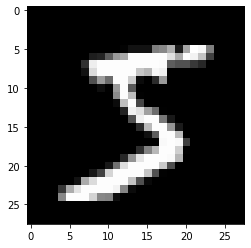

In [5]:
img_norm = denorm(img)
plt.imshow(img_norm[0], cmap="gray")
label

In [6]:
batch_size = 100
data_loader = DataLoader(mnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([8, 6, 9, 0, 9, 7, 7, 4, 5, 1, 8, 3, 8, 5, 6, 2, 4, 0, 4, 2, 9, 0, 0, 7,
        5, 6, 7, 7, 9, 2, 2, 0, 6, 3, 0, 0, 2, 2, 3, 3, 6, 9, 4, 4, 6, 2, 8, 9,
        7, 8, 3, 2, 3, 2, 8, 3, 6, 5, 2, 6, 8, 9, 6, 9, 2, 6, 9, 0, 4, 3, 1, 5,
        3, 4, 3, 6, 1, 7, 3, 7, 3, 4, 3, 0, 8, 0, 4, 2, 5, 3, 5, 2, 7, 6, 0, 4,
        9, 5, 8, 3])


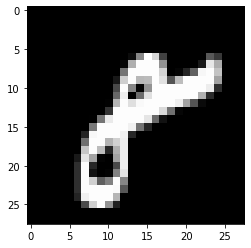

In [7]:
for img_batch, label_batch in data_loader:
    print("first batch")
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap="gray")
    print(label_batch)
    break

# Discriminator Network

In [8]:
image_size = 28 * 28
hidden_size = 256

In [9]:
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid(),
)

Different from the regular ReLU function, Leaky ReLU allows the pass of a small gradient signal for negative values. As a result, it makes the gradients from the discriminator flows stronger into the generator. Instead of passing a gradient (slope) of 0 in the back-prop pass, it passes a small negative gradient. - Source

In [10]:
D

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

# Generator Network

In [11]:
latent_size = 64

In [12]:
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh(),
)

"The ReLU activation (Nair & Hinton, 2010) is used in the generator with the exception of the output layer which uses the Tanh function. We observed that using a bounded activation allowed the model to learn more quickly to saturate and cover the color space of the training distribution. Within the discriminator we found the leaky rectified activation (Maas et al., 2013) (Xu et al., 2015) to work well, especially for higher resolution modeling." - Source

In [13]:
y = G(torch.randn(2, latent_size))
gen_image = denorm(y.reshape((-1, 28, 28)).detach())

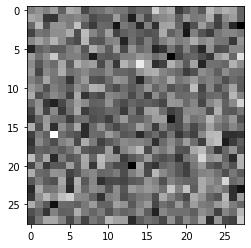

In [14]:
plt.imshow(gen_image[0], cmap="gray")

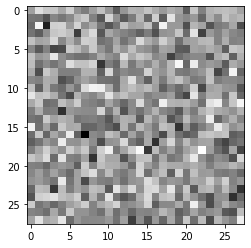

In [15]:
plt.imshow(gen_image[1], cmap="gray")

# Discriminator Training
Since the discriminator is a binary classification model, we can use the binary cross entropy loss function to quantify how well it is able to differentiate between real and generated images.

In [16]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [17]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


def train_discriminator(images):
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    d_loss = d_loss_fake + d_loss_real

    reset_grad()

    d_loss.backward()

    d_optimizer.step()

    return d_loss, real_score, fake_score

# Generator Training

In [18]:
def train_generator():
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

# Training the model 

In [19]:
sample_dir = "samples"
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

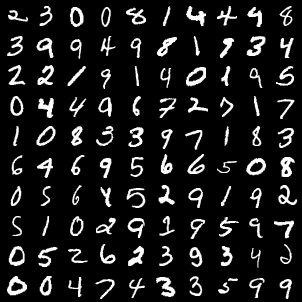

In [20]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, "real_images.png"), nrow=10)
    break

Image(os.path.join(sample_dir, "real_images.png"))

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
device

device(type='cuda')

In [23]:
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [24]:
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

Saving fake_images-0000.png


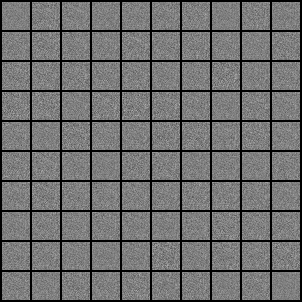

In [25]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)


def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)


# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, "fake_images-0000.png"))

In [26]:
%%time

num_epochs = 50
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i + 1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print(
                "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                    epoch,
                    num_epochs,
                    i + 1,
                    total_step,
                    d_loss.item(),
                    g_loss.item(),
                    real_score.mean().item(),
                    fake_score.mean().item(),
                )
            )

    # Sample and save images
    save_fake_images(epoch + 1)

Epoch [0/50], Step [200/600], d_loss: 0.0425, g_loss: 4.0947, D(x): 0.99, D(G(z)): 0.03
Epoch [0/50], Step [400/600], d_loss: 0.0433, g_loss: 5.7880, D(x): 0.99, D(G(z)): 0.03
Epoch [0/50], Step [600/600], d_loss: 0.0193, g_loss: 5.4432, D(x): 1.00, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/50], Step [200/600], d_loss: 0.0934, g_loss: 5.1678, D(x): 0.96, D(G(z)): 0.02
Epoch [1/50], Step [400/600], d_loss: 0.1756, g_loss: 4.5693, D(x): 0.99, D(G(z)): 0.14
Epoch [1/50], Step [600/600], d_loss: 0.0954, g_loss: 3.9874, D(x): 1.00, D(G(z)): 0.08
Saving fake_images-0002.png
Epoch [2/50], Step [200/600], d_loss: 0.3314, g_loss: 3.8121, D(x): 0.83, D(G(z)): 0.08
Epoch [2/50], Step [400/600], d_loss: 0.2606, g_loss: 3.3697, D(x): 0.91, D(G(z)): 0.13
Epoch [2/50], Step [600/600], d_loss: 0.9410, g_loss: 2.6552, D(x): 0.76, D(G(z)): 0.31
Saving fake_images-0003.png
Epoch [3/50], Step [200/600], d_loss: 0.3318, g_loss: 3.2113, D(x): 0.88, D(G(z)): 0.12
Epoch [3/50], Step [400/600], d_loss

In [27]:
# Save the model checkpoints
torch.save(G.state_dict(), "G.ckpt")
torch.save(D.state_dict(), "D.ckpt")

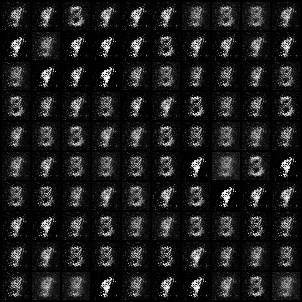

In [28]:
Image("./samples/fake_images-0010.png")

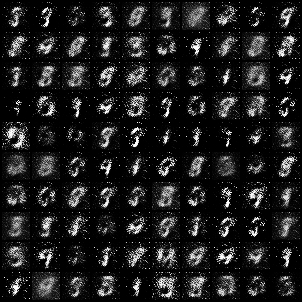

In [29]:
Image("./samples/fake_images-0020.png")

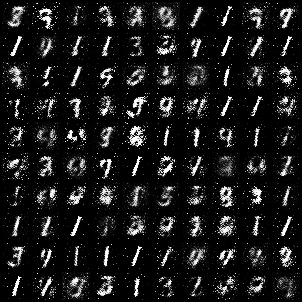

In [30]:
Image("./samples/fake_images-0030.png")

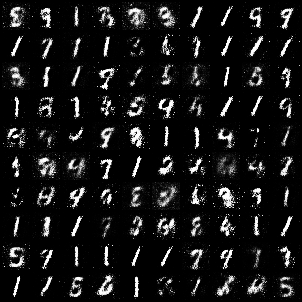

In [31]:
Image("./samples/fake_images-0040.png")

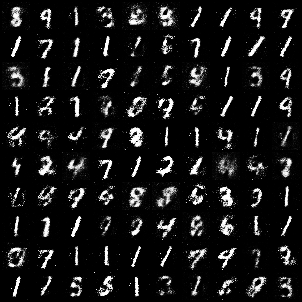

In [32]:
Image("./samples/fake_images-0050.png")

In [33]:
import cv2
import os
from IPython.display import FileLink

vid_fname = "gans_training.avi"

files = [
    os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if "fake_images" in f
]
files.sort()

out = cv2.VideoWriter(vid_fname, cv2.VideoWriter_fourcc(*"MP4V"), 8, (302, 302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink("gans_training.avi")

/content/gans_training.avi

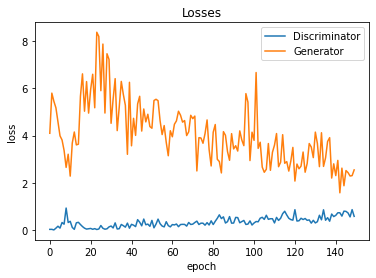

In [34]:
plt.plot(d_losses, "-")
plt.plot(g_losses, "-")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["Discriminator", "Generator"])
plt.title("Losses");

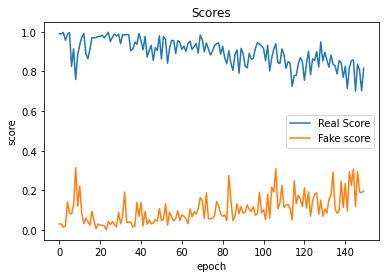

In [35]:
plt.plot(real_scores, "-")
plt.plot(fake_scores, "-")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend(["Real Score", "Fake score"])
plt.title("Scores");

In [38]:
!zip -r samples.zip samples

updating: samples/ (stored 0%)
  adding: samples/fake_images-0024.png (deflated 5%)
  adding: samples/fake_images-0012.png (deflated 5%)
  adding: samples/fake_images-0030.png (deflated 4%)
  adding: samples/fake_images-0045.png (deflated 4%)
  adding: samples/fake_images-0042.png (deflated 4%)
  adding: samples/fake_images-0046.png (deflated 4%)
  adding: samples/fake_images-0004.png (deflated 3%)
  adding: samples/fake_images-0016.png (deflated 5%)
  adding: samples/fake_images-0006.png (deflated 5%)
  adding: samples/fake_images-0009.png (deflated 6%)
  adding: samples/fake_images-0021.png (deflated 5%)
  adding: samples/fake_images-0029.png (deflated 4%)
  adding: samples/fake_images-0011.png (deflated 4%)
  adding: samples/fake_images-0037.png (deflated 4%)
  adding: samples/fake_images-0007.png (deflated 5%)
  adding: samples/fake_images-0027.png (deflated 4%)
  adding: samples/fake_images-0013.png (deflated 5%)
  adding: samples/fake_images-0002.png (deflated 6%)
  adding: sampl